# Project: Predicting Board Game Popularity 

## Dataset and Data Preprocessing

### Importing Necessary Libraries

In [17]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, layers

### Loading the Dataset

In [2]:
# Load the dataset
path_to_csv = "bgg_dataset.csv"

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_to_csv = os.path.join(dirname, filename)

board_games = pd.read_csv(path_to_csv, sep=';')
board_games = pd.DataFrame(board_games)

board_games.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [3]:
# Data Preprocessing

# Convert 'Complexity Average' and 'Rating Average' to numeric
cols_to_convert = ['Complexity Average', 'Rating Average']  

for col in cols_to_convert:
    board_games[col] = board_games[col].replace(',', '.', regex=True).astype(float)

## checking for missing values
board_games.isnull().sum()

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64

In [4]:
# drop 'domain' columns
board_games = board_games.drop(['Domains'], axis=1)

## remove missing values
board_games.dropna(inplace=True)

## checking again
board_games.isnull().sum()

ID                    0
Name                  0
Year Published        0
Min Players           0
Max Players           0
Play Time             0
Min Age               0
Users Rated           0
Rating Average        0
BGG Rank              0
Complexity Average    0
Owned Users           0
Mechanics             0
dtype: int64

In [5]:
print(board_games.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18739 entries, 0 to 20342
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  18739 non-null  float64
 1   Name                18739 non-null  object 
 2   Year Published      18739 non-null  float64
 3   Min Players         18739 non-null  int64  
 4   Max Players         18739 non-null  int64  
 5   Play Time           18739 non-null  int64  
 6   Min Age             18739 non-null  int64  
 7   Users Rated         18739 non-null  int64  
 8   Rating Average      18739 non-null  float64
 9   BGG Rank            18739 non-null  int64  
 10  Complexity Average  18739 non-null  float64
 11  Owned Users         18739 non-null  float64
 12  Mechanics           18739 non-null  object 
dtypes: float64(5), int64(6), object(2)
memory usage: 2.0+ MB
None


## Examinig the dataset

In [6]:
unique_mechanics = set()
board_games['Mechanics'].dropna().apply(lambda x: unique_mechanics.update(x.split(',')))

print("Unique Mechanics:\n", unique_mechanics)
print(len(unique_mechanics))

Unique Mechanics:
 {' Impulse Movement', 'Action Retrieval', 'Map Reduction', 'Speed Matching', ' Time Track', ' Closed Economy Auction', 'Grid Coverage', ' Area-Impulse', 'Card Drafting', 'Chit-Pull System', 'Secret Unit Deployment', 'Force Commitment', ' Pattern Movement', ' Bribery', 'Action Points', ' Ownership', ' Static Capture', 'Pattern Recognition', 'Commodity Speculation', ' Hidden Victory Points', ' Dice Rolling', ' Negotiation', ' Grid Coverage', 'Score-and-Reset Game', 'Deck Bag and Pool Building', ' Increase Value of Unchosen Resources', 'Market', 'Matching', 'Automatic Resource Growth', 'Memory', 'Auction: Dutch Priority', 'Cube Tower', ' Bingo', ' Cube Tower', 'Flicking', 'Trick-taking', ' Auction: Dexterity', 'Voting', ' Player Elimination', ' Action Points', ' Auction: Sealed Bid', 'Map Addition', 'Storytelling', 'Map Deformation', ' Physical Removal', 'Tile Placement', ' Passed Action Token', ' Turn Order: Claim Action', 'Layering', 'Relative Movement', 'Simulation',

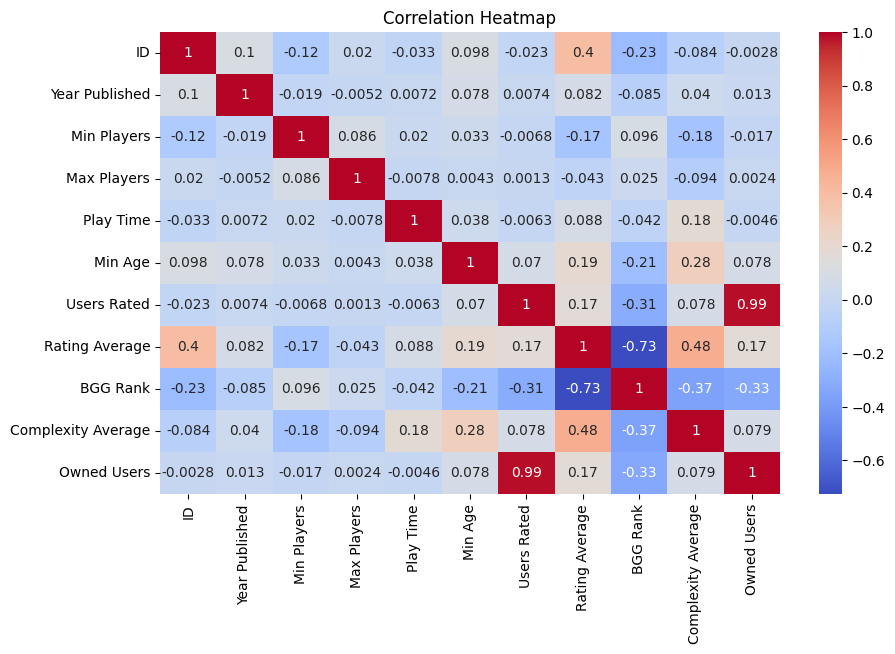

In [7]:
#  Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(board_games.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

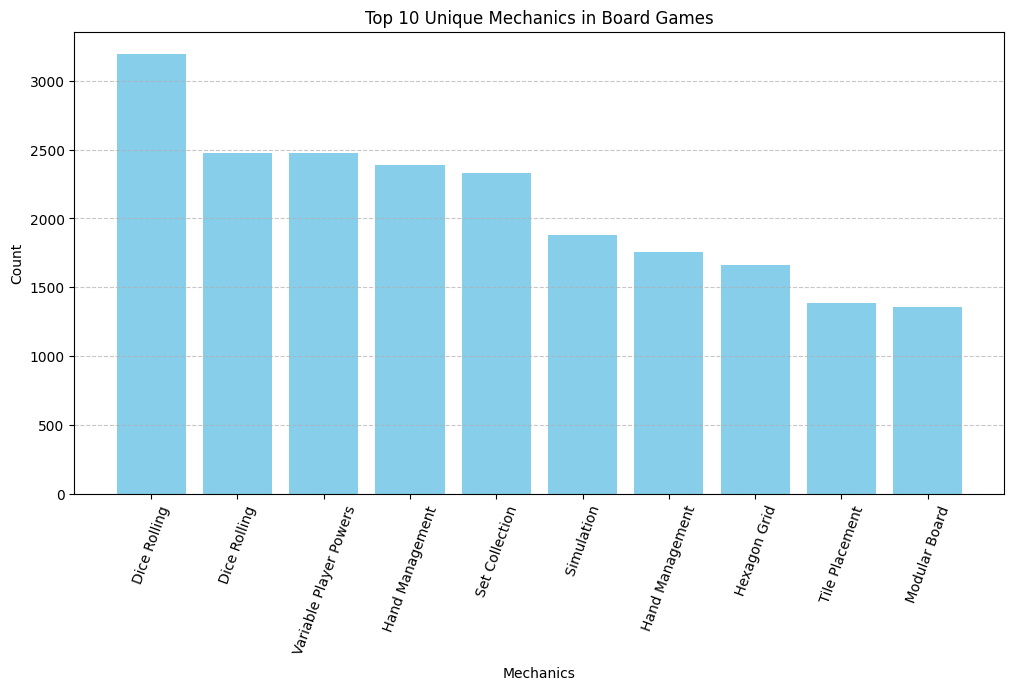

In [8]:
# Mechanics count 
all_mechanics = []
board_games['Mechanics'].dropna().apply(lambda x: all_mechanics.extend(x.split(',')))

mechanic_counts = pd.Series(all_mechanics).value_counts()

mechanic_counts = mechanic_counts.reset_index()
mechanic_counts.columns = ['Mechanic', 'Count']
top_mechanics = mechanic_counts.nlargest(10, 'Count')

plt.figure(figsize=(12, 6))
plt.bar(top_mechanics['Mechanic'], top_mechanics['Count'], color='skyblue')
plt.xticks(rotation=70)  # Rotate x-axis labels for better readability
plt.xlabel('Mechanics')
plt.ylabel('Count')
plt.title('Top 10 Unique Mechanics in Board Games')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Model

In [ ]:
# Function to split the mechanics into individual components
def split_mechanics(mechanics_str):
    return mechanics_str.split(', ')

# Apply CountVectorizer to the 'Mechanics' column
vectorizer = CountVectorizer(tokenizer=split_mechanics, binary=True)

# Fit and transform the mechanics data
mechanics_encoded = vectorizer.fit_transform(board_games['Mechanics'])

# Convert the encoded mechanics to a DataFrame and join with the original DataFrame
mechanics_encoded_df = pd.DataFrame(mechanics_encoded.toarray(), columns=vectorizer.get_feature_names_out())
board_games = pd.concat([board_games, mechanics_encoded_df], axis=1)

# Save the encoder
joblib.dump(vectorizer, 'mechanics_encoder.joblib')

# Prepare feature set and target variable
# Include all one-hot encoded mechanics and selected numerical features
selected_features = ['Complexity Average', 'Play Time', 'Min Players', 'Max Players'] + vectorizer.get_feature_names_out().tolist()
X = board_games[selected_features]
y = board_games['Rating Average']

# Handle missing values in features and target
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Decision Tree

In [10]:
# Decision Tree Regression
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)

print("Decision Tree MSE:", mse_tree)

Decision Tree MSE: 0.7159902004906271


### Random Forest

In [11]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_forest = random_forest.predict(X_test)

# Evaluate the model
mse_forest = mean_squared_error(y_test, y_pred_forest)

print("Random Forest MSE:", mse_forest)

joblib.dump(random_forest, 'random_forest_model.joblib')

Random Forest MSE: 0.3828126699709083


['random_forest_model.joblib']

### Before Tuning Results

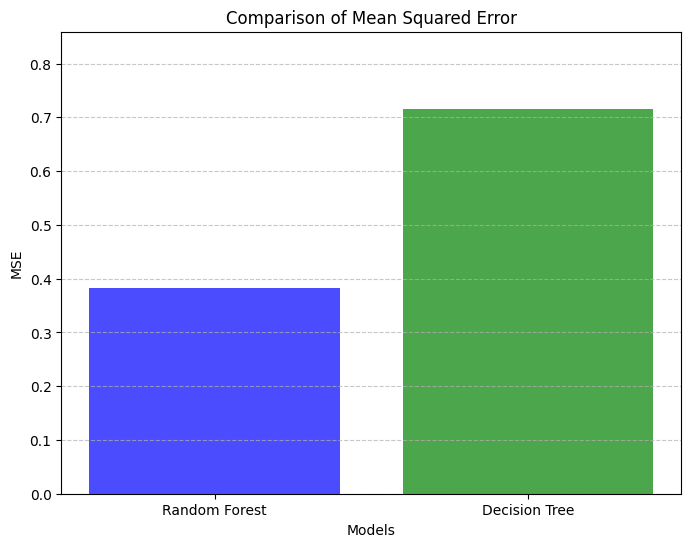

In [12]:
mse_values = {
    "Random Forest": mse_forest,
    "Decision Tree": mse_tree,
}

# Extracting model names and corresponding MSE values
model_names = list(mse_values.keys())
mse_scores = list(mse_values.values())

# Plotting the chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, mse_scores, alpha=0.7, color=['blue', 'green', 'orange'])
plt.title("Comparison of Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Models")
plt.ylim(0, max(mse_scores) * 1.2)  # Adjust y-axis for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Hyperparameter tuning

In [ ]:
# Hyperparameter Tuning for Decision Tree
# Define the parameter grid for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize and perform GridSearchCV for Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(dt_model, param_grid_tree, cv=5, scoring='neg_mean_squared_error')
grid_search_tree.fit(X_train, y_train)

# Evaluate Decision Tree
best_dt_model = grid_search_tree.best_estimator_
y_pred_tree = best_dt_model.predict(X_test)
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))

new_mse_tree = mean_squared_error(y_test, y_pred_tree)

# Save the model 
joblib.dump(best_dt_model, 'decision_tree_model.joblib')

In [ ]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize and perform GridSearchCV for Random Forest
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Evaluate Random Forests
best_rf_model = grid_search_rf.best_estimator_
y_pred_forest = best_rf_model.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_forest))

new_mse_forest = mean_squared_error(y_test, y_pred_forest)

# Save the model 
joblib.dump(best_rf_model, 'random_forest_model.joblib')

### Neural Network

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build neural network model
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
model.add(layers.Dense(128, activation='relu'))  # First hidden layer
model.add(layers.Dropout(0.2))                   # Dropout layer to reduce overfitting
model.add(layers.Dense(64, activation='relu'))   # Second hidden layer
model.add(layers.Dropout(0.2))                   # Dropout layer
model.add(layers.Dense(32, activation='relu'))   # Third hidden layer
model.add(layers.Dense(1))                        # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_mse = model.evaluate(X_test_scaled, y_test)
print("Test Mean Squared Error:", test_mse)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save("neural_network_model.keras")

### After Tuning Results

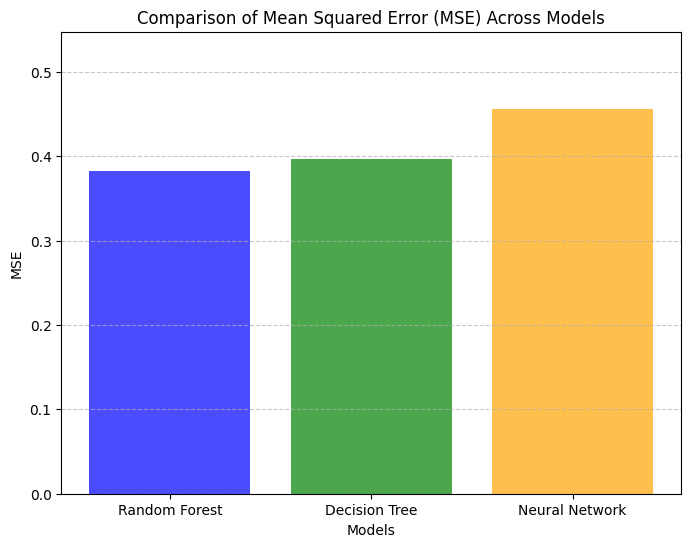

In [20]:
# Create a dictionary of MSE values for different models
mse_values = {
    "Random Forest": mse_forest,
    "Decision Tree": new_mse_tree,
    "Neural Network": test_mse,
}

# Extract model names and MSE values for plotting
model_names = list(mse_values.keys())
mse_scores = list(mse_values.values())

# Plot the MSE comparison chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, mse_scores, alpha=0.7, color=['blue', 'green', 'orange'])
plt.title("Comparison of Mean Squared Error (MSE) Across Models")
plt.ylabel("MSE")
plt.xlabel("Models")
plt.ylim(0, max(mse_scores) * 1.2)  # Adjust y-axis for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Function

In [21]:
# Load the trained models
forest_model = joblib.load('random_forest_model.joblib') 
tree_model = joblib.load('decision_tree_model.joblib')
neural_model = load_model("neural_network_model.keras")

# Load the mechanics encoder 
encoder = joblib.load('mechanics_encoder.joblib')

def assess_popularity(features, model, encoder, scaler=None):
    """
    Predict the average rating (popularity) of a game given its features.
    
    Parameters:
    - features: Dictionary of input features for the game (e.g., 'Complexity Average', 'Play Time', etc.)
    - model: The trained regression model (e.g., Decision Tree, Random Forest, or Neural Network)
    - encoder: The encoder used to encode the 'Mechanics' feature during training
    - scaler: The scaler used for numerical feature scaling (required for Neural Network)
    
    Returns:
    - predicted_rating: The predicted average rating of the game
    """
    # Convert the features to a pandas DataFrame
    game_data = pd.DataFrame([features])

    # Filter mechanics based on the encoder's vocabulary
    vocab = set(encoder.get_feature_names_out())
    game_data['Mechanics'] = game_data['Mechanics'].apply(
        lambda x: ', '.join([m for m in x if m in vocab]) if isinstance(x, list) else str(x)
    )

    # Apply the mechanics_encoder
    mechanics_encoded = encoder.transform(game_data['Mechanics']).toarray()

    # Drop the original 'Mechanics' column and concatenate the encoded mechanics features
    game_data = game_data.drop(columns=['Mechanics'])
    game_data_encoded = pd.concat([game_data, pd.DataFrame(mechanics_encoded)], axis=1)

    # Align features with the model's expected input
    model_columns = model.feature_names_in_ if hasattr(model, "feature_names_in_") else scaler.get_feature_names_out()
    game_data_encoded = game_data_encoded.reindex(columns=model_columns, fill_value=0)

    # Scale numerical features (for Neural Network models)
    if scaler:
        game_data_encoded = scaler.transform(game_data_encoded)

    # Use the trained model to predict the average rating
    predicted_rating = model.predict(game_data_encoded)

    return predicted_rating[0]

### Example

In [22]:
# Example usage:
game_features = {
    'Complexity Average': 3.5,
    'Play Time': 45,
    'Min Players': 2,
    'Max Players': 4,
    'Mechanics': ['Deck Management', 'Dice Rolling']  # Example mechanics
}

# Predict the average rating for the game using each model
rf_rating = assess_popularity(game_features, forest_model, encoder)
dt_rating = assess_popularity(game_features, tree_model, encoder)
nn_rating = assess_popularity(game_features, neural_model, encoder, scaler)

print(f"The predicted average rating (Random Forest): {rf_rating}")
print(f"The predicted average rating (Decision Tree): {dt_rating}")
print(f"The predicted average rating (Neural Network): {nn_rating}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
The predicted average rating (Random Forest): 7.1935999999999956
The predicted average rating (Decision Tree): 7.028481455563337
The predicted average rating (Neural Network): [6.5296364]
